## 2.3 用PyTorch-Lightning实现神经网络实例

### 1 导入所需的库

In [1]:
import os

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning import Trainer
%matplotlib inline

### 为两个框架配置伪随机数生成器以记录结果

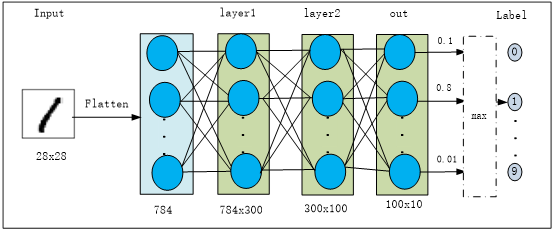

In [2]:
EPOCHS = 10 
torch.random.manual_seed(42)
pl.seed_everything(42)
# 定义一些超参数
train_batch_size = 64
test_batch_size = 128
learning_rate = 0.01
num_workers=8


Global seed set to 42


PyTorch是基于张量计算的，所以在加载数据集之前，您应该定义一组顺序转换，这些转换首先允许将图像转换为张量，然后规范值。您可以立即添加所需的增强，如水平、垂直反射、旋转等，并指定将其应用于每个图像的概率。

In [3]:
#定义预处理函数
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5], [0.5])])
#下载数据，并对数据进行预处理
train_dataset = MNIST('../data/', train=True, transform=transform, download=False)
test_dataset = MNIST('../data/', train=False, transform=transform)
#得到一个生成器
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True,num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False,num_workers=num_workers)

【说明】  
1)	transforms.Compose可以把一些转换函数组合在一起。  从TorchVision.Datasets模块下载数据集。参数应指定train参数的值。如果train=true，则加载训练数据集；如果train=false，则加载测试数据集（如有必要，可以将训练数据集进一步划分为train和validation）。在这里，我们将指定一组转换。
2)	Normalize([0.5], [0.5])对张量进行归一化，这里两个0.5分别表示对张量进行归一化的全局平均值和方差。因图像是灰色的只有一个通道，如果有多个通道，需要有多个数字，如三个通道，应该是Normalize([m1,m2,m3], [n1,n2,n3])。  
3)	download参数控制是否需要下载，如果./data目录下已有MNIST，可选择False。  
4)	用DataLoader得到生成器，这可节省内存。  
5)	torchvision及data的使用第4章将详细介绍。 
6）数据必须传输到DataLoader数据加载程序，DataLoader是PyTorch API的迭代器，允许您以批量的形式加载数据。必须在batchu size参数中指定以图像数表示的所需batch大小。

为了验证数据是否正确，可以检查结果。

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

### 可视化源数据

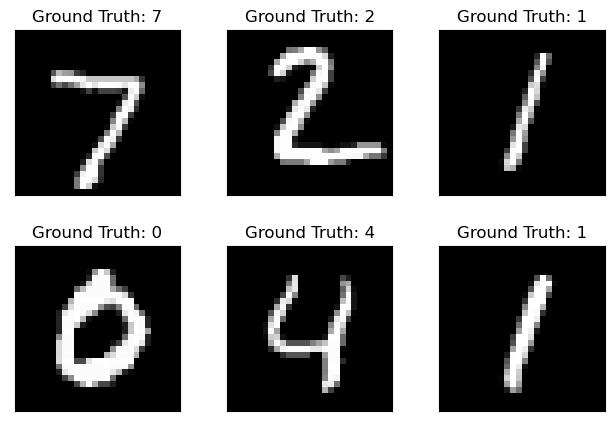

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

使用PyTorch Lightning。当使用不同的框架时，算法的工作原理不会改变，但是接口允许以不同的方式实现它。在这种情况下，模型的步骤和优化器的配置是由模型类中的方法定义的，而不是编写循环，在这种情况下，可以定义数据加载程序的工作。PyTorch Lightning是一个非常灵活的工具。下面是一个类似于前一个神经网络的例子。

### 2.定义LightningModule

In [6]:
class Pytorch_Lightning_MNIST_Classifier(pl.LightningModule):
  
  def __init__(self):
    super().__init__()
    # 定神经网络的结构
    self.layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(28 * 28 * 1, 300),
      nn.ReLU(),
      nn.Linear(300, 100),
      nn.ReLU(),
      nn.Linear(100, 10)
    )
    # 构建损失函数
    self.loss_func = nn.CrossEntropyLoss()
    
  def forward(self, x):
    
    return self.layers(x)
  
  # 定义超参数
  def training_step(self, batch, batch_idx):
    x, y = batch
    pred = self.layers(x)
    loss = self.loss_func(pred, y)
    self.log('train_loss', loss)
    return loss
  
  # 配置测试参数
  def test_step(self, batch, batch_idx):
    x, y = batch
    pred = self.layers(x)
    loss = self.loss_func(pred, y)
    pred = torch.argmax(pred, dim=1)
    accuracy = torch.sum(y == pred).item() / (len(y) * 1.0)
    self.log('test_loss', loss, prog_bar=True)
    self.log('test_acc', torch.tensor(accuracy), prog_bar=True)
    output = dict({
        'test_loss': loss,
        'test_acc': torch.tensor(accuracy),
    })
    return output

  # 配置优化器的参数
  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
    return optimizer

### 3. 创建pl.Trainer对象
PyTorch Lightning提供了一个特殊的trainer（）函数来训练和测试模型，该函数具有广泛的设置，例如，如果我们处理分布式计算，您可以手动指定图形处理器的数量。在开始学习之前，trainer（）将检查GPU或TPU的可用性，并将计算切换到可用的，您必须手动在PyTorch中指定。
trainer（）添加了许多经典ML方法，如fit、test、predict。

In [7]:
# 初始化Trainer模型和功能
model = Pytorch_Lightning_MNIST_Classifier()

### 查看模型结构

In [8]:
# 查看模型结构
summary=pl.utilities.model_summary.ModelSummary(model,max_depth=-1)  
print(summary)

  | Name      | Type             | Params
-----------------------------------------------
0 | layers    | Sequential       | 266 K 
1 | layers.0  | Flatten          | 0     
2 | layers.1  | Linear           | 235 K 
3 | layers.2  | ReLU             | 0     
4 | layers.3  | Linear           | 30.1 K
5 | layers.4  | ReLU             | 0     
6 | layers.5  | Linear           | 1.0 K 
7 | loss_func | CrossEntropyLoss | 0     
-----------------------------------------------
266 K     Trainable params
0         Non-trainable params
266 K     Total params
1.066     Total estimated model params size (MB)


### 保存模型

In [9]:
#定义包括模型的回调函数
ckpt_callback = pl.callbacks.ModelCheckpoint(
    monitor='train_loss',
    save_top_k=1,
    mode='min'
)
#定义提取终止的条件
early_stopping = pl.callbacks.EarlyStopping(monitor = 'train_loss',
               patience=3,
               mode = 'min')

In [10]:
trainer = pl.Trainer(accelerator="auto",devices=1,callbacks = [ckpt_callback,early_stopping],max_epochs=EPOCHS)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [11]:
# 培训模型
trainer.fit(model, train_loader)

# 模型测试
trainer.test(model,test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | layers    | Sequential       | 266 K 
1 | loss_func | CrossEntropyLoss | 0     
-----------------------------------------------
266 K     Trainable params
0         Non-trainable params
266 K     Total params
1.066     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9657999873161316     │
│         test_loss         │    0.11615342646837234    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.11615342646837234, 'test_acc': 0.9657999873161316}]

### 装载模型

In [12]:
print(trainer.checkpoint_callback.best_model_path)
print(trainer.checkpoint_callback.best_model_score)

C:\Users\wumg\jupyter-ipynb\AIGC-Book\AIGC-02\lightning_logs\version_11\checkpoints\epoch=4-step=4690.ckpt
tensor(0.0302, device='cuda:0')


### 4.装载模型

In [13]:
model_clone = model.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
trainer_clone = pl.Trainer(accelerator="auto",devices=1,max_epochs=3) 
result = trainer_clone.test(model_clone,test_loader)
print(result)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9521999955177307     │
│         test_loss         │    0.16526885330677032    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.16526885330677032, 'test_acc': 0.9521999955177307}]


### 5. 把PyTorch转换为pl代码的对应关系

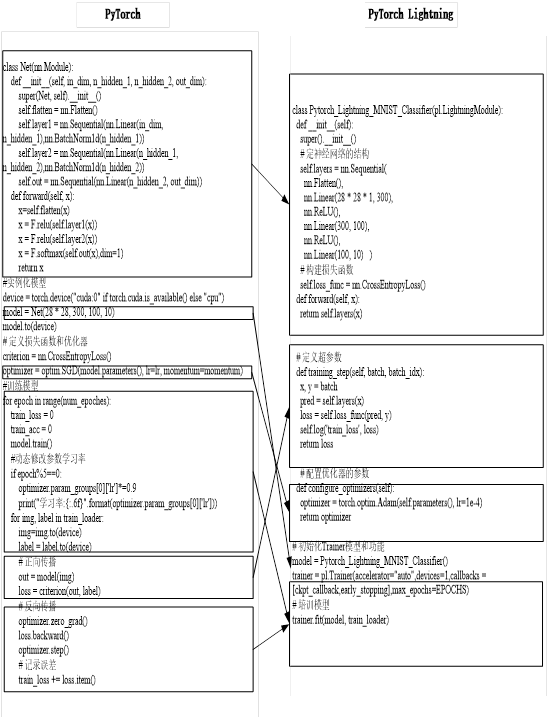

## 以下是参考博客

https://blog.51cto.com/u_16159492/6481711

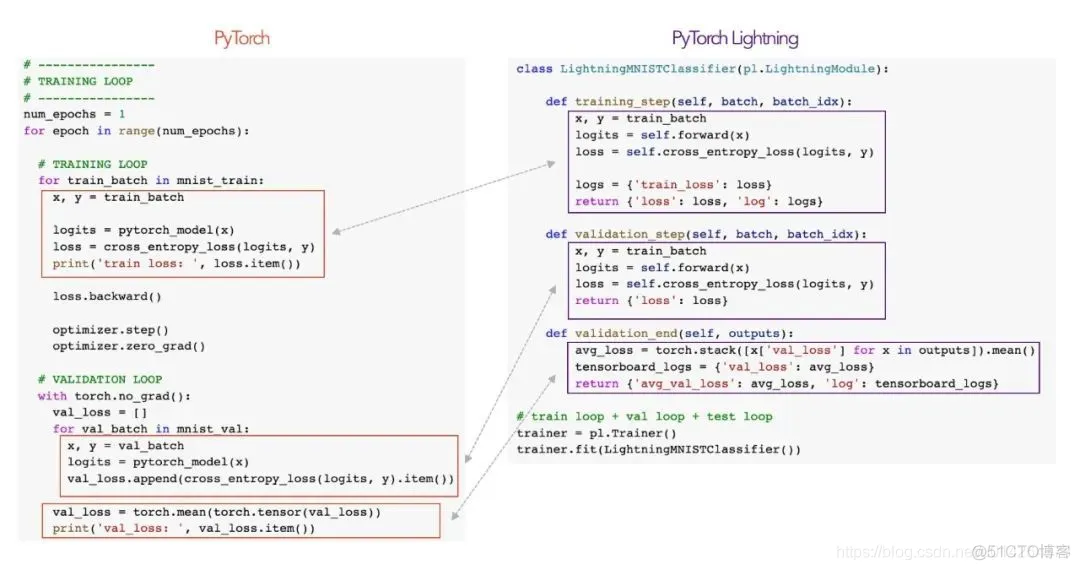

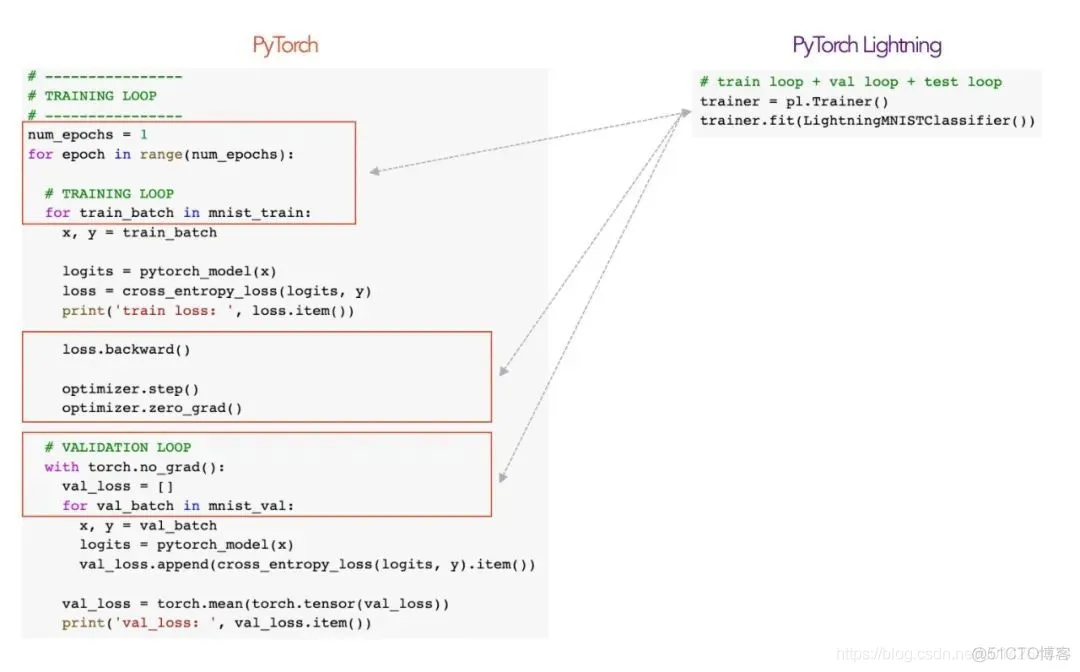

https://learnopencv.com/getting-started-with-pytorch-lightning/

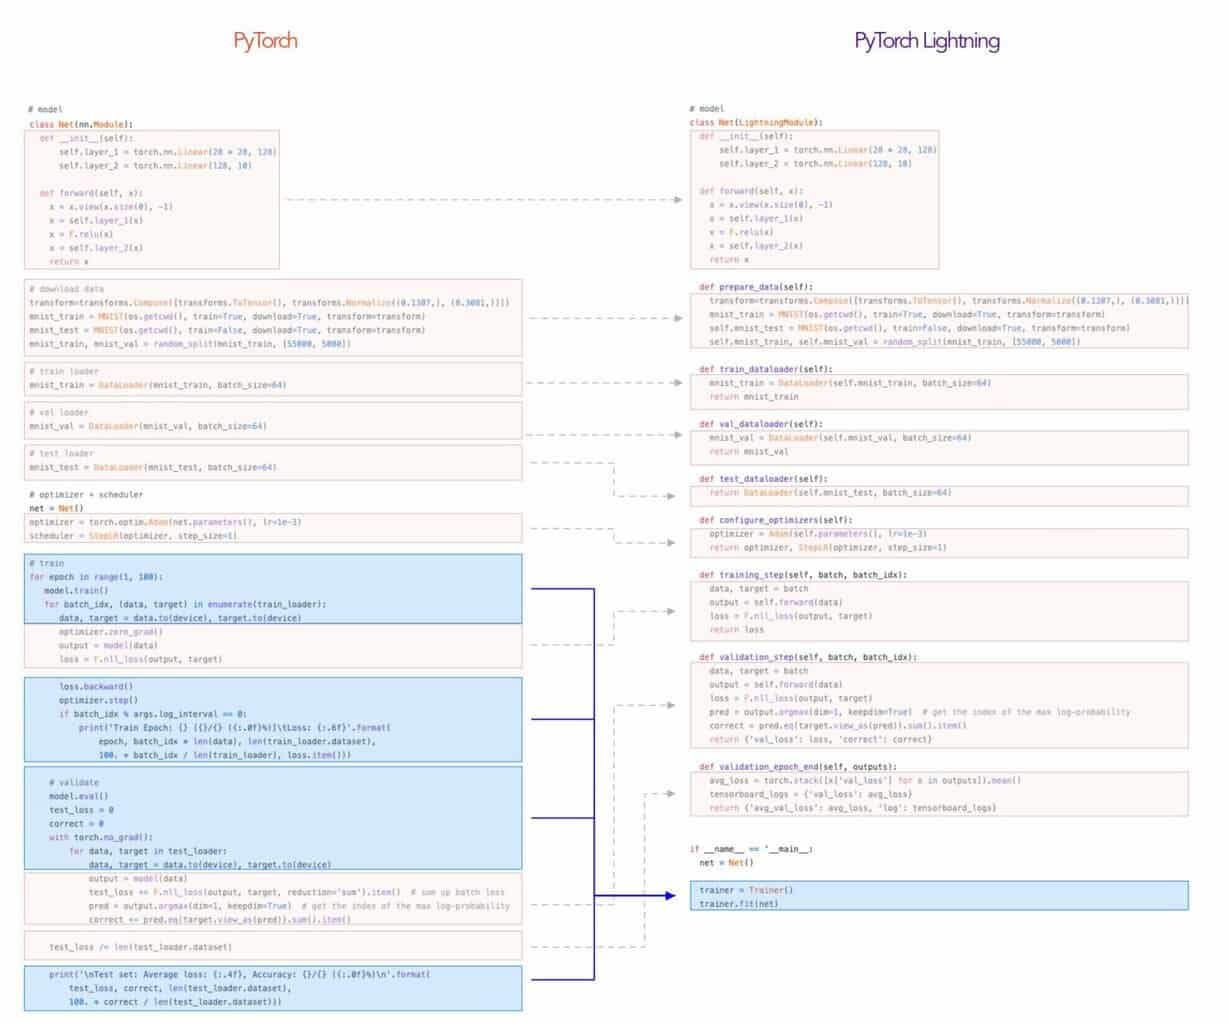

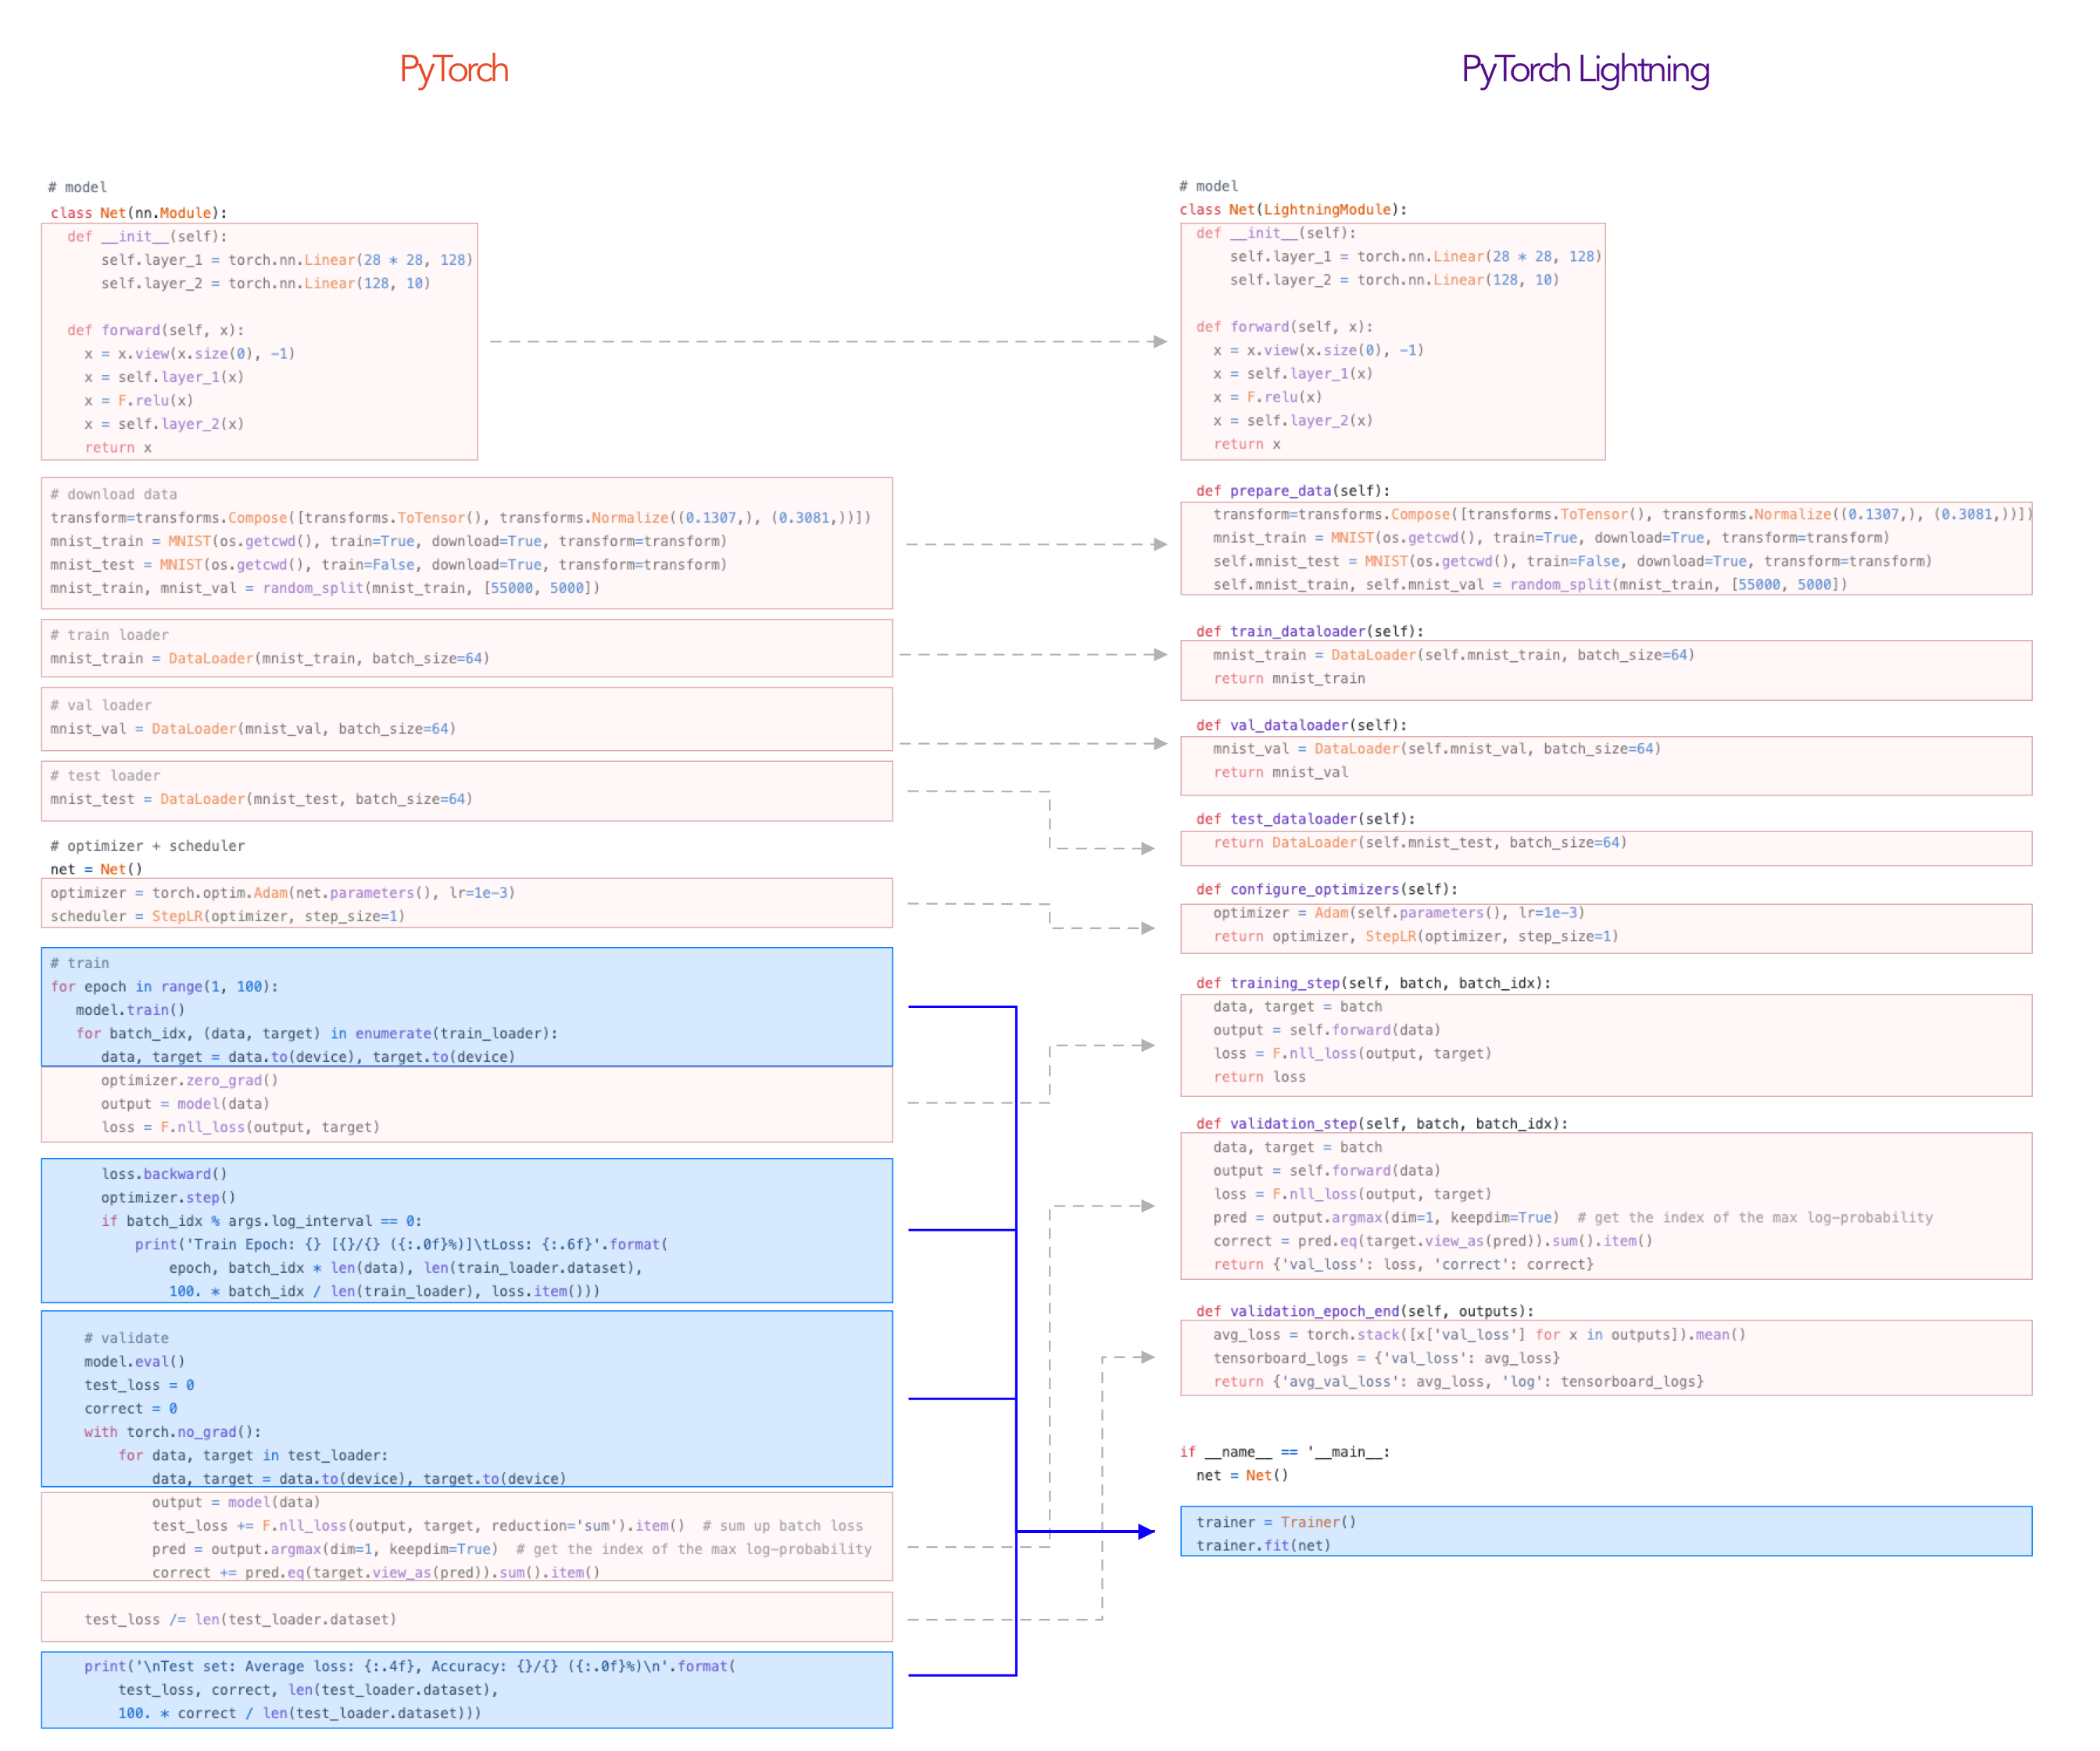